## Import data

In [1]:
import numpy as np
import pandas as pd
import glob
# from sklearn.model_selection import train_test_split

In [2]:
WINDOW_SIZE = 166
WINDOW_STRIDE = 83

# Use the same number of windows for each movement
SAME_WINDOW_COUNT = True

In [3]:
files = glob.glob("../data/*.csv")

# list of dataframes
dataframes = []

for f in files:
    dataframes.append(pd.read_csv(f))

In [4]:
windows_all_movements = [[],[],[],[],[],[],[],[],[],[],[]]
labels_all_movements = [[],[],[],[],[],[],[],[],[],[],[]]
groups_all_movements = [[],[],[],[],[],[],[],[],[],[],[]]

movement_index_map = {
    'Jalka sivulle oikea': 0,
    'Jalka sivulle vasen': 1,
    'Jalka taakse oikea': 2,
    'Jalka taakse vasen': 3,
    'Jalkanosto oikea': 4,
    'Jalkanosto vasen': 5,
    'Not movement active': 6,
    'Polvinosto oikea': 7,
    'Polvinosto vasen': 8,
    'Seiso ylös': 9,
    'Varpaille': 10,
}

# all_windows = []
# all_labels = []
# all_groups = []

for index, df in enumerate(dataframes):

    df = df[~df.Movement.isin(['Start calibration', 'End calibration', 'Not movement', 'Seiso ylös sensor vaihto', 'Not movement inactive'])]
    sensor_placement_groups = df.groupby('SensorPlacement')
    left_sensor_df = sensor_placement_groups.get_group('left').copy()
    right_sensor_df = sensor_placement_groups.get_group('right').copy()

    left_movement_groups = left_sensor_df.groupby("Movement", sort=False)
    right_movement_groups = right_sensor_df.groupby("Movement", sort=False)

    for group_name, left_df in left_movement_groups:
        right_df = right_movement_groups.get_group(group_name)

        # Sorting is required by merge_asof later
        # Done just in case. Data should be sorted from the start
        # Sorting can be checked with the following
        # left_df["Timestamp"].is_monotonic_increasing
        left_df = left_df.sort_values(by=['Timestamp'])
        right_df = right_df.sort_values(by=['Timestamp'])

        # Movement and Start are dropped on the right dataframe because the data 
        # will be combined with the data from the left sensor on the closest timestep.
        # We do not want to duplicate this data from both sensors
        # drop columns that are not needed and rename remaining
        left_df.drop(['SensorPlacement', 'MagnX', 'MagnY', 'MagnZ'], axis=1, inplace=True)
        left_df.rename(columns = {'AccX':'lax', 'AccY':'lay', 'AccZ':'laz', 'GyroX':'lgx', 'GyroY':'lgy', 'GyroZ':'lgz'}, inplace = True)

        right_df.drop(['Movement', 'SensorPlacement', 'Start', 'MagnX', 'MagnY', 'MagnZ'], axis=1, inplace=True)
        right_df.rename(columns = {'AccX':'rax', 'AccY':'ray', 'AccZ':'raz', 'GyroX':'rgx', 'GyroY':'rgy', 'GyroZ':'rgz',}, inplace = True)

        # combine left and right sensor dataframes on the nearest timestamp using left-join
        combined_df = pd.merge_asof(left_df, right_df, on='Timestamp', direction='nearest')

        # remove all timesteps before the first and after the last movement start indicator
        # this removes bad data that is added at the start and end of recording sessions
        # The first movement is also lost but it is easier to place a pause in between movements
        start_df = combined_df[combined_df["Start"] == 1]
        if group_name not in ['Not movement', 'Not movement active', 'Not movement inactive']:
            combined_df = combined_df.loc[(combined_df["Timestamp"] > start_df.iloc[0,0]) & (combined_df["Timestamp"] < start_df.iloc[-1, 0]), :]
        
        windows = []
        labels = []
        groups = []

        # Save windows to different list in order to use the same amount of data
        # from each movement

        for i in range(0, len(combined_df) - WINDOW_SIZE, WINDOW_STRIDE):
            window_df = combined_df.iloc[i:i+WINDOW_SIZE].copy()
            labels.append(movement_index_map.get(group_name))
            groups.append(index)
            window_df.drop(['Timestamp', 'Start', 'Movement'], axis=1, inplace=True)
            window_df = window_df.T
            windows.append(window_df.values.tolist())
        
        windows_all_movements[movement_index_map[group_name]].extend(windows)
        labels_all_movements[movement_index_map[group_name]].extend(labels)
        groups_all_movements[movement_index_map[group_name]].extend(groups)
        
        # all_windows.extend(windows)
        # all_labels.extend(labels)
        # all_groups.extend(groups)

In [5]:
# all_windows = np.asarray(all_windows)
# all_labels = np.asarray(all_labels)

In [6]:
# Use only the same number of windows for each movement

if SAME_WINDOW_COUNT:
    min = len(windows_all_movements[0])
    for index, movement_windows in enumerate(windows_all_movements):
        print(f'Movement: {index}, {len(movement_windows)}')
        if len(movement_windows) < min:
            min = len(movement_windows)

    for index, movement_windows in enumerate(windows_all_movements):
        del movement_windows[min:]
        del labels_all_movements[index][min:]
        del groups_all_movements[index][min:]

Movement: 0, 169
Movement: 1, 170
Movement: 2, 184
Movement: 3, 184
Movement: 4, 185
Movement: 5, 178
Movement: 6, 267
Movement: 7, 177
Movement: 8, 174
Movement: 9, 247
Movement: 10, 181


In [7]:
for index, movement_windows in enumerate(windows_all_movements):
    print(f'Movement: {index}, {len(movement_windows)}')

Movement: 0, 169
Movement: 1, 169
Movement: 2, 169
Movement: 3, 169
Movement: 4, 169
Movement: 5, 169
Movement: 6, 169
Movement: 7, 169
Movement: 8, 169
Movement: 9, 169
Movement: 10, 169


In [8]:
all_windows = []
all_labels = []
all_groups = []

for movement_windows in windows_all_movements:
    all_windows.extend(movement_windows)

for movement_labels in labels_all_movements:
    all_labels.extend(movement_labels)

for movement_groups in groups_all_movements:
    all_groups.extend(movement_groups)

In [9]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
from aeon.classification.convolution_based import RocketClassifier
from aeon.classification.interval_based import DrCIFClassifier
from aeon.classification.shapelet_based import RDSTClassifier
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from aeon.classification.feature_based import FreshPRINCEClassifier
from aeon.classification.dictionary_based import MUSE
from aeon.classification.dictionary_based import TemporalDictionaryEnsemble
from aeon.classification.hybrid import HIVECOTEV2
from aeon.classification.deep_learning import InceptionTimeClassifier
from aeon.classification.convolution_based import MultiRocketHydraClassifier
from aeon.classification.interval_based import RSTSF
import time

In [23]:
# Not efficient, should use lists
test_labels = np.array([])
predictions = np.array([])
all_scores = []
data_list = []

logo = LeaveOneGroupOut()


for train, test in logo.split(all_windows, all_labels, groups=all_groups):

    train_x = np.take(all_windows, train, 0)
    train_y = np.take(all_labels, train, 0)
    test_x = np.take(all_windows, test, 0)
    test_y = np.take(all_labels, test, 0)

    # classifier = RocketClassifier(n_jobs=8)
    # classifier = KNeighborsTimeSeriesClassifier(n_jobs=-1)
    # classifier = FreshPRINCEClassifier(n_jobs=8)
    classifier = RSTSF(n_jobs=-1)
    # classifier = RDSTClassifier(n_jobs=8)
    # classifier = MUSE(n_jobs=8)
    # classifier = MultiRocketHydraClassifier(n_jobs=8)
    # classifier = InceptionTimeClassifier()
    #classifier = HIVECOTEV2(n_jobs=8)

    fit_time = 0
    predict_time = 0

    t0 = time.perf_counter()
    classifier.fit(train_x, train_y)
    t1 = time.perf_counter()
    fit_time = t1-t0

    t0 = time.perf_counter()
    y_pred = classifier.predict(test_x)
    t1 = time.perf_counter()
    predict_time = t1-t0

    accuracy = accuracy_score(test_y, y_pred)
    
    print(f"Accuracy: {accuracy}")

    # print(score)
    row = [accuracy, fit_time, predict_time]
    data_list.append(row)

    test_labels = np.concatenate((test_labels, test_y))
    predictions = np.concatenate((predictions, y_pred))


Accuracy: 0.9820627802690582
Accuracy: 0.9778761061946902
Accuracy: 0.9803921568627451
Accuracy: 0.968503937007874
Accuracy: 0.9084507042253521
Accuracy: 0.8422712933753943
Accuracy: 0.8580645161290322
Accuracy: 0.8362068965517241
Accuracy: 0.9935897435897436
Accuracy: 0.9545454545454546


In [24]:
result_df = pd.DataFrame(data_list, columns =['accuracy', 'fit_time', 'predict_time']) 

In [25]:
result_df

,accuracy,fit_time,predict_time
0,0.982063,441.139640,11.431976
1,0.977876,414.927086,10.783061
2,0.980392,417.385284,11.221769
3,0.968504,414.077907,11.804652
4,0.908451,408.533661,9.121268
5,0.842271,341.098979,12.547976
6,0.858065,399.203351,9.510431
7,0.836207,406.740309,7.675673
8,0.993590,408.840245,10.467867
9,0.954545,460.176613,7.517636


In [26]:
tot_accuaracy = accuracy_score(test_labels, predictions)
print(f"Total accuracy: {tot_accuaracy}, Min accuracy: {result_df['accuracy'].min()}, Max accuracy: {result_df['accuracy'].max()}, STD accuracy: {result_df['accuracy'].std()} Total fit time: {result_df['fit_time'].sum()}, Total predict time: {result_df['predict_time'].sum()}")

Total accuracy: 0.9306078536847767, Min accuracy: 0.8362068965517241, Max accuracy: 0.9935897435897436, STD accuracy: 0.06307216743213721 Total fit time: 4112.123075931006, Total predict time: 102.08230853300483


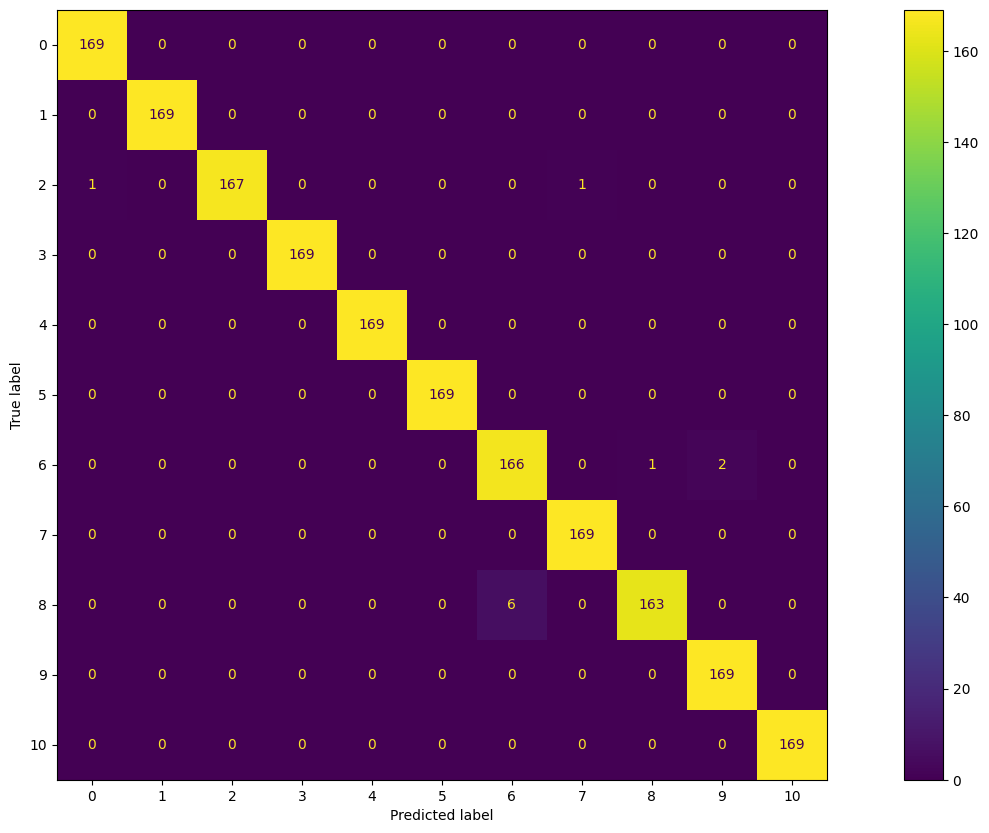

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

cm = confusion_matrix(test_labels, predictions)
# cm = confusion_matrix(validation_y, y_pred, normalize='all')

cm_display = ConfusionMatrixDisplay(cm).plot()


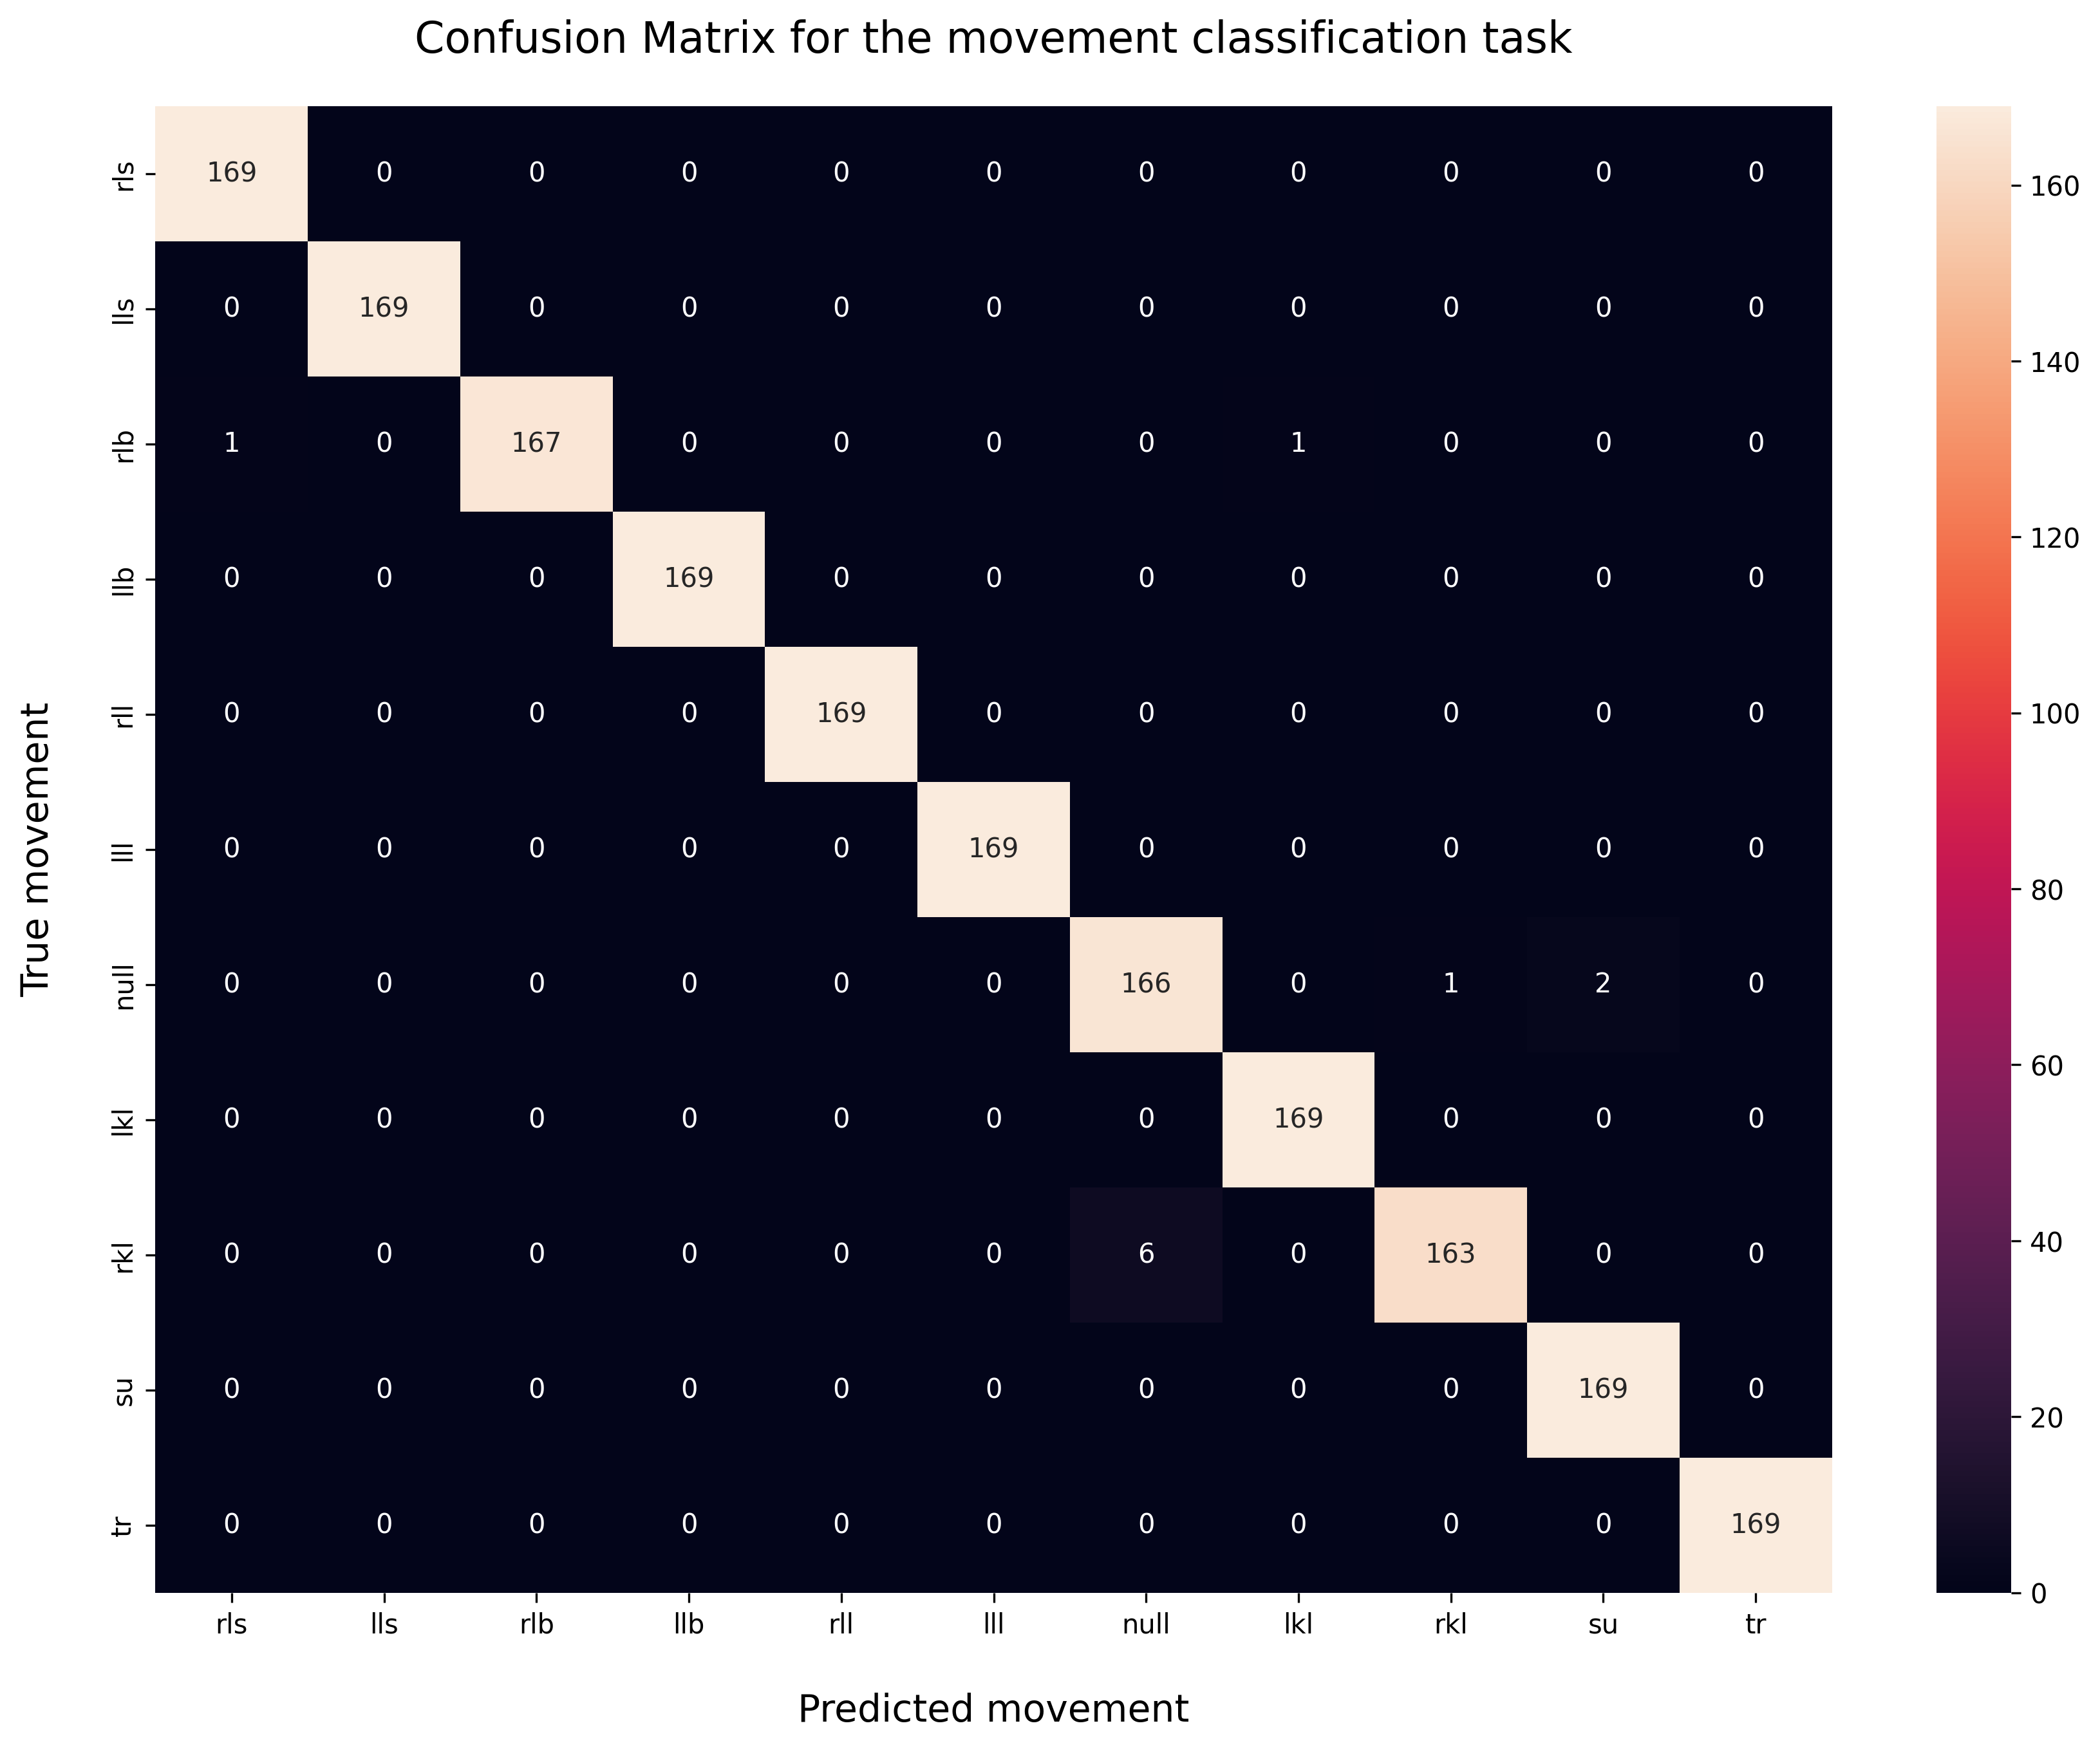

In [22]:
import seaborn as sns

plt.figure(figsize=(14,10), dpi=300)
 
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm, annot=True, fmt='d')
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted movement", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['rls', 'lls', 'rlb', 'llb', 'rll', 'lll', 'null', 'lkl', 'rkl', 'su', 'tr'])
 
# set y-axis label and ticks
ax.set_ylabel("True movement", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['rls', 'lls', 'rlb', 'llb', 'rll', 'lll', 'null', 'lkl', 'rkl', 'su', 'tr'])
 
# set plot title
ax.set_title("Confusion Matrix for the movement classification task", fontsize=16, pad=20)
 
plt.show()

## Plot where the errors happen for the worst user and worst movement